# Input Parameters
Example with 3 jobs 3 machines

In [25]:
TASKS = {
('Job1', 'Machine1'): {'dur': 2, 'prec': None},
('Job1', 'Machine2'): {'dur': 1, 'prec': ('Job1', 'Machine1')},
('Job1', 'Machine3'): {'dur': 3, 'prec': ('Job1', 'Machine2')},
('Job2', 'Machine1'): {'dur': 2, 'prec': None},
('Job2', 'Machine3'): {'dur': 3, 'prec': ('Job2', 'Machine1')},
('Job2', 'Machine2'): {'dur': 2, 'prec': ('Job2', 'Machine3')},
('Job3', 'Machine2'): {'dur': 3, 'prec': None},
('Job3', 'Machine3'): {'dur': 4, 'prec': ('Job3', 'Machine2')},
('Job3', 'Machine1'): {'dur': 3, 'prec': ('Job3', 'Machine3')},
}
energy_rates = {
('Job1', 'Machine1'): 19,
('Job1', 'Machine2'): 21,
('Job1', 'Machine3'): 18,
('Job2', 'Machine1'): 16,
('Job2', 'Machine3'): 11,
('Job2', 'Machine2'): 25,
('Job3', 'Machine2'): 15,
('Job3', 'Machine3'): 14,
('Job3', 'Machine1'): 15,
}

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import csv
import time
import re
from matplotlib.ticker import MultipleLocator, FuncFormatter
from pyomo.environ import *
from pyomo.gdp import * 


In [27]:
battery_capacity = 50.0  # B_cap in kWh
battery_charge_limit = 10.0  # B_ch in kW
battery_discharge_limit = 10.0  # B_dch in kW

In [28]:
# Sample TOU rates for 24 hour period. Euros per kWh. 00:00am - 00:00am
tou_rates = [0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20]
            

In [29]:
#Future predicted PV power output from the predictive model. 
predicted_PV_output_list = []

with open ("future_PV_power_predictions.csv", "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader) #Skip heading row
    
    for row in csv_reader:
        predicted_PV_output_list.append(float(row[1]) / 1000)

# Since the predicted PV power is in 1 hour timeslots, kwh = kw * 1, so 1 kw = 1 kwh
print("Predicted PV Power Output (kwh):", predicted_PV_output_list) 
pv_generation = predicted_PV_output_list


Predicted PV Power Output (kwh): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013315345644197002, 1.540759301508539, 5.61706915723522, 12.170022727772519, 18.48596663794175, 24.899722330831604, 29.1803339748038, 29.601265304319696, 26.05379478407932, 23.094599619165198, 20.66625185177326, 17.092988958301756, 11.071651576238104, 4.538172624134009, 0.34020652368160353, 0.0, 0.0, 0.0, 0.0]


In [30]:
# Define minimum start time for the first task, e.g. 2 = 02:00, 4 = 04:00, 18 = 18:00
minimum_start_time = 0

# Define time when all tasks must be completed by. 23 = 23:00, but 25 = 01:00 the following day, 27 = 03:00 the following day
deadline = 12


time_slots = range(minimum_start_time, deadline)

# Defining MILP

In [31]:
def jobshop_model(TASKS):
    
    # Initialise the model
    model = ConcreteModel()

    # Set of time periods in the makespan
    model.Tp = Set(initialize=time_slots)

    # Set of tasks (job, machine)
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # Set of jobs
    model.J = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # Set of machines
    model.M = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # The order of tasks is constructed as a cross-product of tasks and filtering
    # The task (k,n) is the task preceding task (j,m)
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4, 
            filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])
    
    


    # Parameters
    
    # Time of Use electricity rates
    model.Rg = Param(model.Tp, initialize={t: tou_rates[t] for t in model.Tp})
    
    # PV energy generated per time interval
    model.Gs = Param(model.Tp, initialize={t: pv_generation[t] for t in model.Tp})
    
    # Capacity of battery
    model.B_cap = Param(initialize=battery_capacity)
    
    # Charge limit of battery
    model.B_ch = Param(initialize=battery_charge_limit)
    
    # Discharge limit of battery
    model.B_dch = Param(initialize=battery_discharge_limit)
    
    # Duration of each task
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])
    
    # Energy consumption of each task
    model.ejm = Param(model.J, model.M, initialize=energy_rates)
    
    # Initial charge in battery at start of time horizon
    model.B_initial = Param(initialize=0) 


    # Decision varaibles
    
    # Energy drawn from grid
    model.Et_grid = Var(model.Tp, domain=NonNegativeReals)
    
    # Energy drawn from PV system
    model.Et_pv = Var(model.Tp, domain=NonNegativeReals)
    
    # Energy charged into battery system
    model.Et_in = Var(model.Tp, domain=NonNegativeReals)
    
    # Energy discharged from battery system
    model.Et_out = Var(model.Tp, domain=NonNegativeReals)
    
    # Charge in battery
    model.Bt = Var(model.Tp, domain=NonNegativeReals, bounds=(0, model.B_cap))
    
    # Binary variable, 1 if battery is charging during time interval t, 0 if not
    model.Ct = Var(model.Tp, domain=Binary) 
    
    # Binary variable, 1 if battery is discharging during time interval t, 0 if not
    model.Dt = Var(model.Tp, domain=Binary)
    
    # Binary variable, 1 if job j starts processing on machine m during time interval t, 0 otherwise
    model.Xjmt = Var(model.J, model.M, model.Tp, domain=Binary) 
    
    # Binary variable, 1 if job j is being processed on machine m at time t, 0 otherwise
    model.Yjmt = Var(model.J, model.M, model.Tp, domain=Binary)
    
    # Deadline to complete all tasks
    model.deadline = Var(bounds=(0, deadline))
   
    
    
    # Objective Function. The electricity cost in Euros. 
    def objective_rule(model):
        # Sum of product of TOU electricity rate and energy drawn from grid across all time periods
        return sum(model.Rg[t] * model.Et_grid[t] for t in model.Tp)
    model.Objective = Objective(rule=objective_rule, sense=minimize)

    # Constraints

    def electricity_balance_rule(model, t):
        return model.Et_grid[t] + model.Et_pv[t] + model.Et_out[t] - model.Et_in[t] == sum(model.ejm[j, m] * model.Yjmt[j, m, t] for j in model.J for m in model.M)
    model.ElectricityBalance = Constraint(model.Tp, rule=electricity_balance_rule)

    def pv_power_constraint_rule(model, t):
        return model.Et_pv[t] <= model.Gs[t]
    model.PVPowerConstraint = Constraint(model.Tp, rule=pv_power_constraint_rule)

    def battery_capacity_limit_rule(model, t):
        return model.Bt[t] <= model.B_cap
    model.BatteryCapacityLimit = Constraint(model.Tp, rule=battery_capacity_limit_rule)

    def battery_charging_limit_rule(model, t):
        return model.Et_in[t] <= model.B_ch * model.Ct[t]
    model.BatteryChargingLimit = Constraint(model.Tp, rule=battery_charging_limit_rule)

    def battery_discharging_limit_rule(model, t):
        return model.Et_out[t] <= model.B_dch * model.Dt[t]
    model.BatteryDischargingLimit = Constraint(model.Tp, rule=battery_discharging_limit_rule)
    
    # Battery can either be charging or discharging, not both
    def charging_discharging_rule(model, t):
        return model.Ct[t] + model.Dt[t] <= 1
    model.ChargingDischarging = Constraint(model.Tp, rule=charging_discharging_rule)
    
    # Finding the charge in battery during time interval t
    def battery_balancing_rule(model, t):
        if t == model.Tp.first(): #To handle any initial charge in the battery before the first time step
            return model.Bt[t] == model.B_initial + model.Et_in[t] - model.Et_out[t]
        else:
            previous_t = model.Tp.prev(t)
            return model.Bt[t] == model.Bt[previous_t] + model.Et_in[t] - model.Et_out[t]
    model.BatteryBalancing = Constraint(model.Tp, rule=battery_balancing_rule)
    
    # For each job j and machine m, if xjmt = 1, then yjmt should be 1 for the full duration of the job processing time
    # Iterate over each time interval in the processing duration of the task to sum up the value of yjmt. t' is the iterating variable
    def job_running_rule(model, j, m, t):
        return sum(model.Yjmt[j, m, t_prime] for t_prime in range(t, min(t + model.dur[j, m], deadline))) >= model.dur[j, m] * model.Xjmt[j, m, t]
    model.JobRunning = Constraint(model.J, model.M, model.Tp, rule=job_running_rule)

    # Ensures that each task in each job in TASKS is processed only once. 
    def job_processing_requirement_rule(model, j, m):
        if (j, m) in model.TASKS:  # Only apply if the job-machine pair is in TASKS
            return sum(model.Xjmt[j, m, t] for t in model.Tp) == 1
        else:
            return Constraint.Skip  # Skip the constraint for job-machine pairs not in TASKS
    model.JobProcessingRequirement = Constraint(model.J, model.M, rule=job_processing_requirement_rule)
    
    # Ensures all jobs must be finished before the specified deadline
    def finish_rule(model, j, m):
        return sum(t * model.Xjmt[j, m, t] for t in model.Tp) + model.dur[j, m] <= model.deadline
    model.finish = Constraint(model.TASKS, rule=finish_rule)

   # Ensures that for each job, a task cannot start until the preceding task has finished
    def preceding_rule(model, j, m, k, n):
        return sum(t * model.Xjmt[k, n, t] for t in model.Tp) + model.dur[k, n] <= sum(t * model.Xjmt[j, m, t] for t in model.Tp)
    model.preceding = Constraint(model.TASKORDER, rule=preceding_rule)

    # Ensure that a machine can only process one job at a time
    def machine_processing(model, m, t):
        return sum(model.Xjmt[j, m, tp] for j in model.J for tp in model.Tp if tp <= t and tp > t - model.dur[j, m]) <= 1
    model.MachineProcessing = Constraint(model.M, model.Tp, rule=machine_processing)


    
    return model
jobshop_model(TASKS)

# Solving MILP

In [32]:
def jobshop_solve(model):
    
    # Solve the model using the Gurobi solver
    SolverFactory('gurobi').solve(model)

    # Initialise an empty list to store results
    results = []

    # Iterate over each task in the model
    for j, m in model.TASKS:
        # Calculate the start time for the task
        start_time = sum(t * model.Xjmt[j, m, t].value for t in model.Tp)
        
        # Get the duration of the task
        duration = model.dur[j, m]
        
        # Calculate the finish time
        finish_time = start_time + duration  

        # Append the task details to the results list
        results.append({
            'Job': j,
            'Machine': m,
            'Start': start_time,
            'Duration': duration,
            'Finish': finish_time
        })

    return results

In [33]:
# Create and solve the model
created_model = jobshop_model(TASKS)

# Time how long it takes the model to solve
start_timing = time.time()

results = jobshop_solve(created_model)

end_timing = time.time()

time_taken_to_solve = end_timing - start_timing

print(f"Time taken = {time_taken_to_solve} seconds")

# Display the total electricity costs (objective function value)
total_electricity_costs = created_model.Objective.expr()
print(f"Total Electricity Costs: €{total_electricity_costs}")

# Print the timings of the tasks
print("Scheduling Results:")
for res in results:
    print(f"Job: {res['Job']}, Machine: {res['Machine']}, Start: {res['Start']}, Duration: {res['Duration']}, Finish: {res['Finish']}")


#Display the results
created_model.display()


Time taken = 0.3499331474304199 seconds
Total Electricity Costs: €72.620072729057
Scheduling Results:
Job: Job1, Machine: Machine1, Start: 2.0, Duration: 2, Finish: 4.0
Job: Job1, Machine: Machine2, Start: 4.0, Duration: 1, Finish: 5.0
Job: Job1, Machine: Machine3, Start: 9.0, Duration: 3, Finish: 12.0
Job: Job2, Machine: Machine1, Start: 0.0, Duration: 2, Finish: 2.0
Job: Job2, Machine: Machine3, Start: 2.0, Duration: 3, Finish: 5.0
Job: Job2, Machine: Machine2, Start: 5.0, Duration: 2, Finish: 7.0
Job: Job3, Machine: Machine2, Start: 0.0, Duration: 3, Finish: 3.0
Job: Job3, Machine: Machine3, Start: 5.0, Duration: 4, Finish: 9.0
Job: Job3, Machine: Machine1, Start: 9.0, Duration: 3, Finish: 12.0
Model unknown

  Variables:
    Et_grid : Size=12, Index=Tp
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :     0 :               31.0 :  None : False : False : NonNegativeReals
          1 :     0 :               31.0 :  None : False : False : NonNegat

# Visualising Results

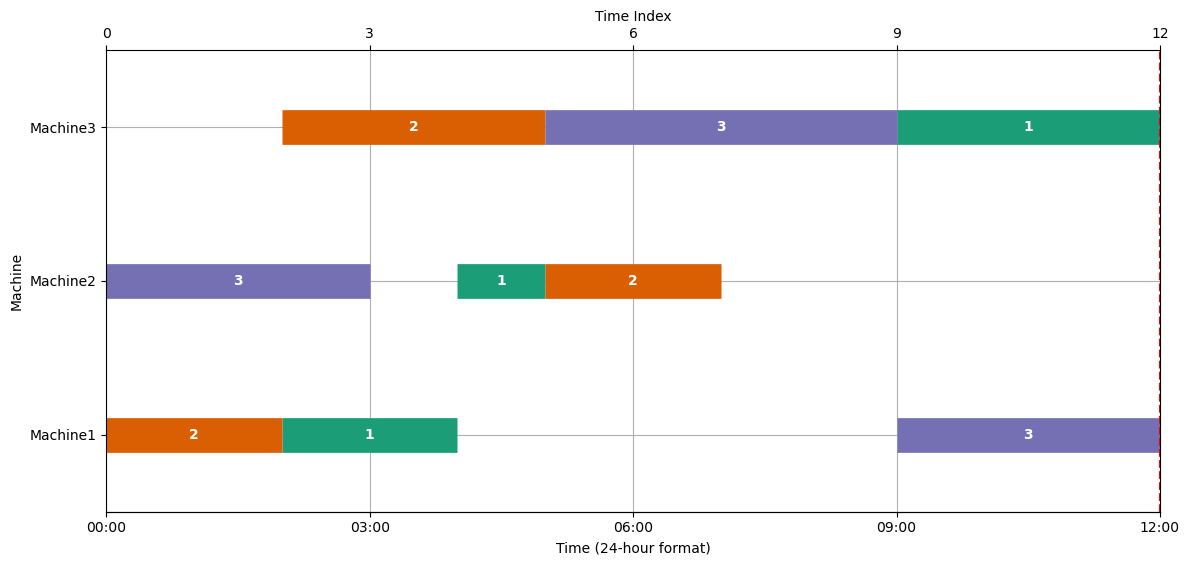

In [34]:
# Function to visualise the results
def visualise(results, deadline):
    schedule = pd.DataFrame(results)
    MACHINES = sorted(schedule['Machine'].unique(), key=lambda x: int(re.search(r'\d+', x).group()))
    deadline = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(figsize=(12, 5 + len(MACHINES) / 4))

    for mdx, m in enumerate(MACHINES, 1):
        job_entries = schedule.xs(m, level='Machine')
        for jdx, (j, row) in enumerate(job_entries.iterrows()):
            xs = row['Start']
            xf = row['Finish']
            job_number = re.search(r'\d+', j).group()
            ax.plot([xs, xf], [mdx] * 2, c=colors[jdx % len(colors)], **bar_style)
            ax.text((xs + xf) / 2, mdx, job_number, **text_style)

    ax.set_xlabel('Time Index')
    ax.set_ylabel('Machine')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_xlim(0, deadline)
    ax.set_ylim(0.5, len(MACHINES) + 0.5)
    ax.set_yticks(range(1, 1 + len(MACHINES)))
    ax.set_yticklabels(MACHINES)

    ax.plot([deadline] * 2, ax.get_ylim(), 'r--')

    # Bottom x-axis in 24-hour format
    def convert_to_24h(x, pos):
        """Converts an hour to 24-hour format, resetting every 24 hours."""
        return '{:02d}:{:02d}'.format(int(x % 24), int((x % 1) * 60))
    ax2 = ax.secondary_xaxis('bottom', functions=(lambda x: x, lambda x: x))
    ax2.xaxis.set_major_formatter(FuncFormatter(convert_to_24h))
    ax2.xaxis.set_major_locator(MultipleLocator(3))
    ax2.set_xlabel('Time (24-hour format)')

    ax.grid(True)

    fig.tight_layout()
    plt.show()

visualise(results, deadline)


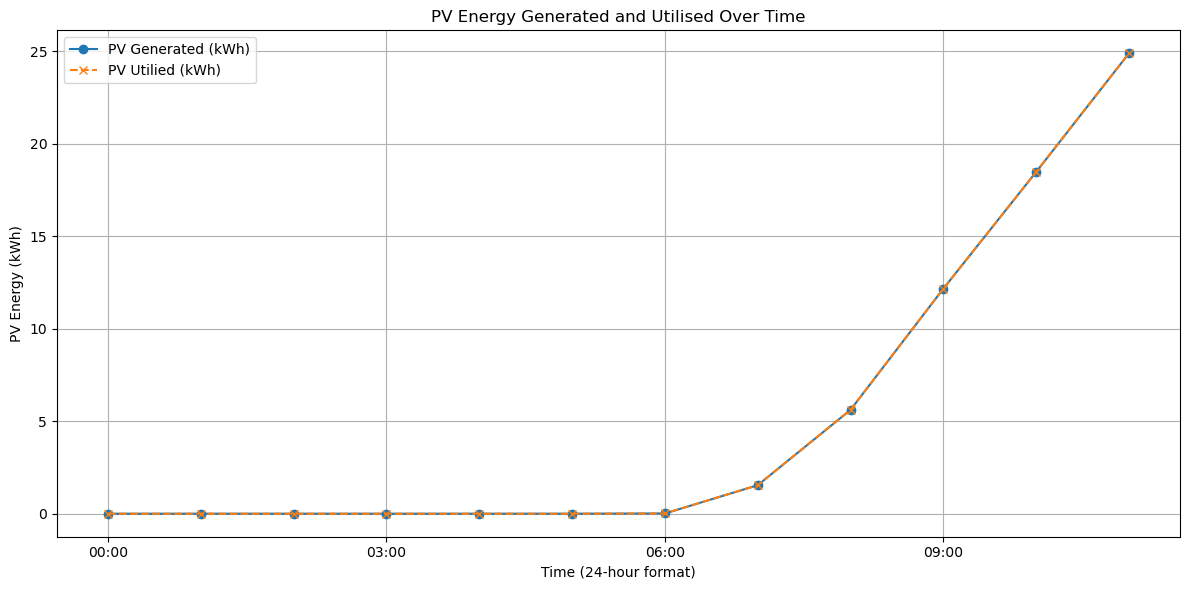

In [35]:
# Function to plot the PV energy used
def plot_pv_energy(model):
    time_slots = list(model.Tp)

    # Fetch the generated and utilised PV energy
    pv_generated = [model.Gs[t] for t in time_slots]
    pv_utilised = [model.Et_pv[t].value for t in time_slots]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_slots, pv_generated, label='PV Generated (kWh)', marker='o', linestyle='-')
    plt.plot(time_slots, pv_utilised, label='PV Utilied (kWh)', marker='x', linestyle='--')

    # Setting the labels for the x-axis and y-axis
    plt.xlabel('Time (24-hour format)')
    plt.ylabel('PV Energy (kWh)')
    plt.title('PV Energy Generated and Utilised Over Time')

    # Define the format of the x-axis labels to show time in 24-hour format
    formatter = FuncFormatter(lambda x, pos: '{:02d}:00'.format(int(x % 24)))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_locator(MultipleLocator(3))  # Set major ticks to every 3 hours

    # Adding grid, legend, and tight layout
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()


plot_pv_energy(created_model)


In [36]:
# Function to calculate the PV energy utilised
def calculate_pv_utilization(model):
    
    # Summing up all generated PV energy over the given time horizon
    total_pv_generated = sum(model.Gs[t] for t in model.Tp)

    # Summing up all utilized PV energy as per the model's results
    total_pv_utilized = sum(model.Et_pv[t].value for t in model.Tp)

    # Calculating the percentage of PV energy utilized
    if total_pv_generated > 0:
        percentage_pv_utilized = (total_pv_utilized / total_pv_generated) * 100
    else:
        percentage_pv_utilized = 0  # Avoid division by zero if no PV energy is generated

    return total_pv_generated, total_pv_utilized, percentage_pv_utilized

# Using the function with the created model
total_pv_generated, total_pv_utilized, percentage_pv_utilized = calculate_pv_utilization(created_model)

print(f"Total PV Generated: {total_pv_generated} kWh")
print(f"Total PV Utilized: {total_pv_utilized} kWh")
print(f"Percentage of PV Utilized: {percentage_pv_utilized:.2f}%")


Total PV Generated: 62.72685550093384 kWh
Total PV Utilized: 62.72685550093384 kWh
Percentage of PV Utilized: 100.00%


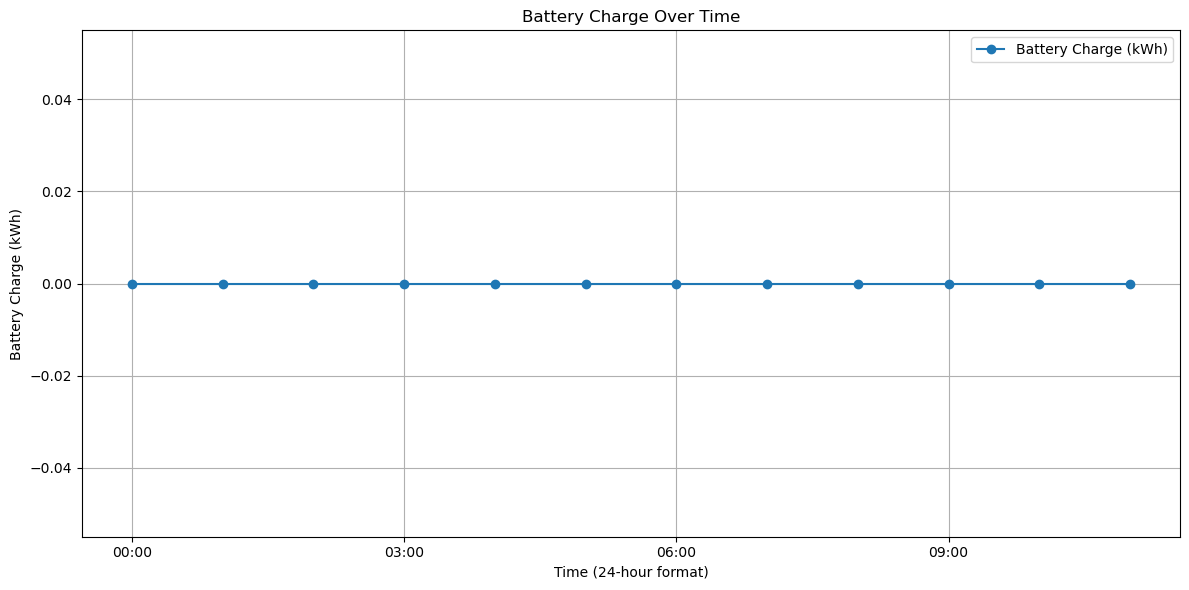

In [37]:
# Function to plot the battery level over the time horizon
def plot_battery_level(model):
    
    # Extract battery level at each time period from the model
    battery_levels = [model.Bt[t].value for t in model.Tp] 

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(list(model.Tp), battery_levels, label='Battery Charge (kWh)', marker='o', linestyle='-')

    # Setting the labels and titles of the plot
    plt.xlabel('Time (24-hour format)')
    plt.ylabel('Battery Charge (kWh)')
    plt.title('Battery Charge Over Time')

    # Define the format of the x-axis labels to show time in 24-hour format
    formatter = FuncFormatter(lambda x, pos: '{:02d}:00'.format(int(x % 24)))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_locator(MultipleLocator(3))  # Set major ticks to every 3 hours

    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()


plot_battery_level(created_model)


[31.0, 31.0, 45.0, 30.0, 32.0, 39.0, 38.986684654355805, 12.459240698491461, 8.382930842764779, 20.82997727222748, 14.51403336205825, 8.100277669168396]


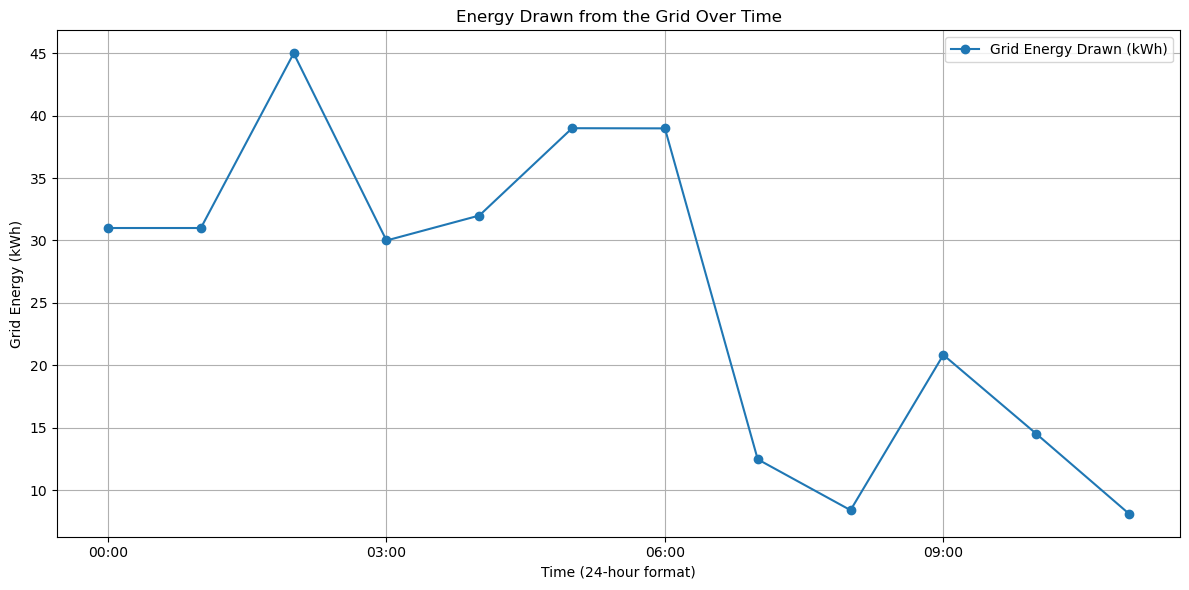

In [38]:
# Function to plot the energy drawn from the grid over the time horizon
def plot_grid_energy(model):
    
    # Extract grid power at each time period from the model
    grid_energy = [model.Et_grid[t].value for t in model.Tp]  
    print(grid_energy)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(list(model.Tp), grid_energy, label='Grid Energy Drawn (kWh)', marker='o', linestyle='-')

    # Setting the labels and titles of the plot
    plt.xlabel('Time (24-hour format)')
    plt.ylabel('Grid Energy (kWh)')
    plt.title('Energy Drawn from the Grid Over Time')

    # Define the format of the x-axis labels to show time in 24-hour format
    formatter = FuncFormatter(lambda x, pos: '{:02d}:00'.format(int(x % 24)))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_locator(MultipleLocator(3))  # Set major ticks to every 3 hours

    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_grid_energy(created_model)
